# SLIM MODEL
Since the KNN_Item_CF is the one that perfomed the best so far, now i'm trying a SLIM Model, which is basically the same algorithm but Machine Learning based. It uses the infos from the training data instead of some heuristic (such as cosine similarity ecc...)
https://notebook.community/trangel/Insight-Data-Science/general-docs/recommendation-validation/.ipynb_checkpoints/recommender_systems-validation-checkpoint

# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
unique_users, min_users, max_users = len(dataset.row.unique()), dataset.row.min(), dataset.row.max()
unique_items, min_items, max_items = len(dataset.col.unique()), dataset.col.min(), dataset.col.max()
print('users stats:',unique_users, min_users, max_users)
print('items stats:',unique_items, min_items, max_items)

users stats: 7947 0 7946
items stats: 24896 0 25974


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

CSR basically has a pointer to the exact beginning of every possible row. For example if i have <code>matrix.inptr = [0,1,2,4,6] </code> this means that at <code>matrix.inptr[n]</code> I have my n row which "last" until the next cell in the array. <br> In this case (for example) my third row goes from 2 to 4. <br>

What do I do with it? <br>

I use this index (2 to 4) to access the other two arrays of the crs format: <code>indices</code> and <code>data</code>.
<code>indices</code> gives me the column index and <code>data</code> gives me the actual data to take

In [5]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [6]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

The following 2 graphs plots the <code>items_per_user</code> and the <code>users_per_item</code>. It shows that slightly more than 2500 users and 2500 items have a 0 count. This is coherent with the original data we got: 30910-27255 for users and 18494-15277 for items. These differences are the missing users/items in the dataset (Basically users/items that have no interaction at all)

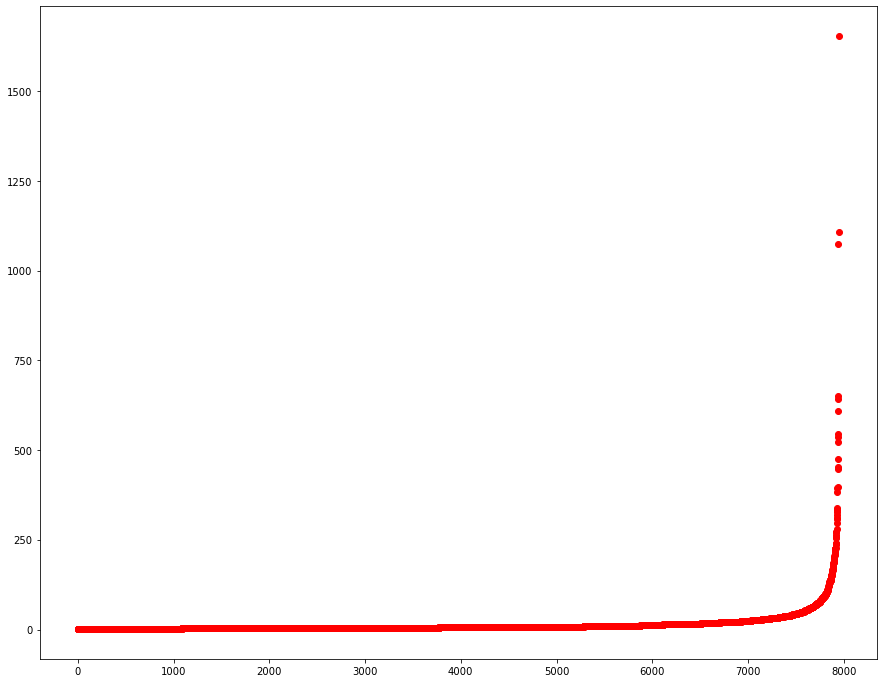

In [7]:
plt.figure(figsize=(15,12))
plt.plot(items_per_user, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

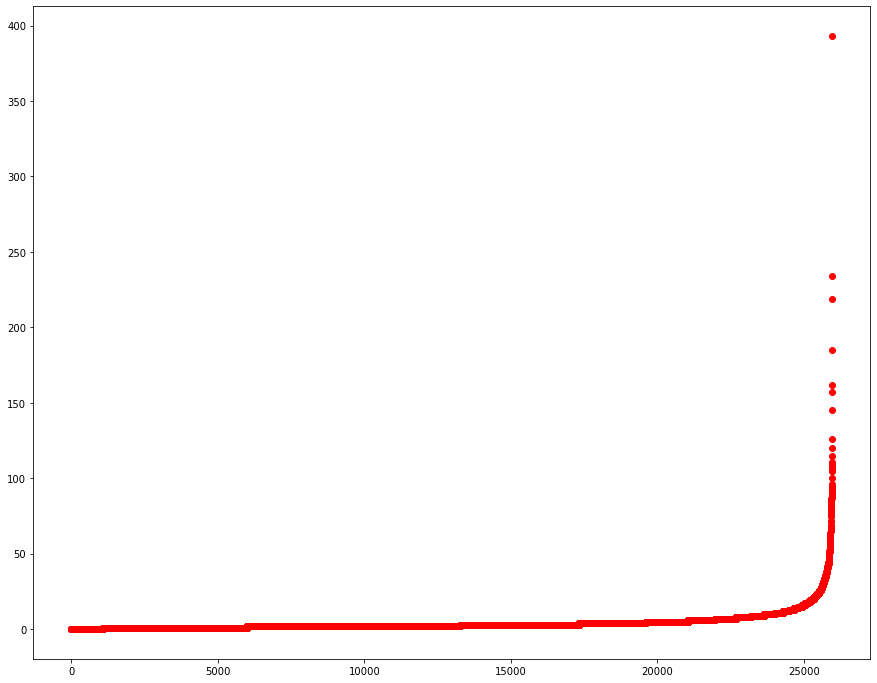

In [8]:
plt.figure(figsize=(15,12))
plt.plot(users_per_item, 'ro') #biased dataset, but not so much compared with the one seen at lessons 

In [9]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [10]:
unique_items, min_items, max_items = len(ICM_df.row.unique()), ICM_df.row.min(), ICM_df.row.max()
unique_features, min_features, max_features = len(ICM_df.col.unique()), ICM_df.col.min(), ICM_df.col.max()
print('items stats:',unique_items, min_items, max_items)
print('features stats:',unique_features, min_features, max_features)

items stats: 25950 0 25974
features stats: 19998 0 19999


In [11]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [12]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [13]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

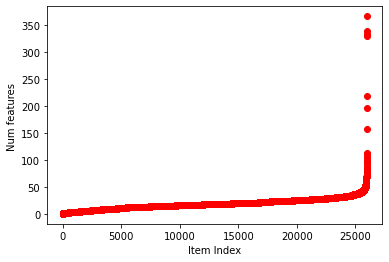

In [14]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

plt.plot(features_per_item, 'ro')
plt.ylabel('Num features ')
plt.xlabel('Item Index')
plt.show()

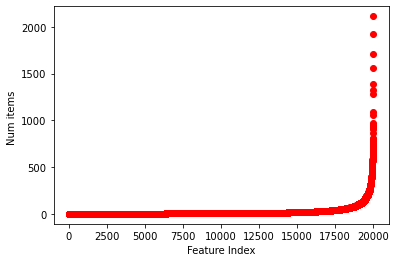

In [15]:
plt.plot(items_per_feature, 'ro')
plt.ylabel('Num items ')
plt.xlabel('Feature Index')
plt.show()

In [16]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [19]:
URM_all

<7947x25975 sparse matrix of type '<class 'numpy.float64'>'
	with 113268 stored elements in Compressed Sparse Row format>

In [20]:
ICM_all

<25975x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 490691 stored elements in Compressed Sparse Row format>

In [21]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [22]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommender = ItemKNNCBFRecommender(URM_train, ICM_all)

ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.


In [26]:
x_tick = []
collaborative_MAP = []

for topK in [50,100,200,300,400,500,600]:
    for shrink in [1,5,10,50,100,200,400,500]:
        for weighting in ['none', 'BM25', 'TF-IDF']:

            x_tick.append("topk {}, shrink{}, weight{}".format(topK,shrink, weighting))


            recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
            recommender.fit(topK=topK, shrink=shrink, feature_weighting = weighting)

            result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

            collaborative_MAP.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3490.72 column/sec, elapsed time 0.12 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 3.36 sec. Users per second: 1502
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3290.73 column/sec, elapsed time 0.13 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 3.50 sec. Users per second: 1441
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3301.91 column/sec, elapsed time 0.13 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 3.60 sec. Users per second: 1401
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 340

Similarity column 25975 ( 100 % ), 2514.35 column/sec, elapsed time 0.17 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.70 sec. Users per second: 1072
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2735.85 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.72 sec. Users per second: 1068
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2788.80 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.62 sec. Users per second: 1091
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2685.12 column/sec, elapsed time 0.16 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 6.05 sec. Users per second: 833
Ite

ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3181.93 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.01 sec. Users per second: 1257
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3197.58 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 3.82 sec. Users per second: 1318
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3271.65 column/sec, elapsed time 0.13 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.07 sec. Users per second: 1239
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 332

Similarity column 25975 ( 100 % ), 2368.48 column/sec, elapsed time 0.18 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.89 sec. Users per second: 1031
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2610.58 column/sec, elapsed time 0.17 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 3.98 sec. Users per second: 1266
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3174.54 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.71 sec. Users per second: 1072
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3135.85 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.08 sec. Users per second: 1236
It

EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.32 sec. Users per second: 1167
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2883.29 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.38 sec. Users per second: 1152
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3058.72 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.31 sec. Users per second: 1171
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2886.49 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.26 sec. Users per second: 1184
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommend

ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2999.77 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.42 sec. Users per second: 1140
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 3036.21 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.33 sec. Users per second: 1165
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 2967.57 column/sec, elapsed time 0.15 min
EvaluatorHoldout: Processed 5043 ( 100.00% ) in 4.41 sec. Users per second: 1143
ItemKNNCBFRecommender: URM Detected 50 (0.63 %) cold users.
ItemKNNCBFRecommender: URM Detected 1992 (7.67 %) cold items.
Similarity column 25975 ( 100 % ), 235

In [38]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

161 0.03153040849825289
topk 600, shrink200, weightTF-IDF


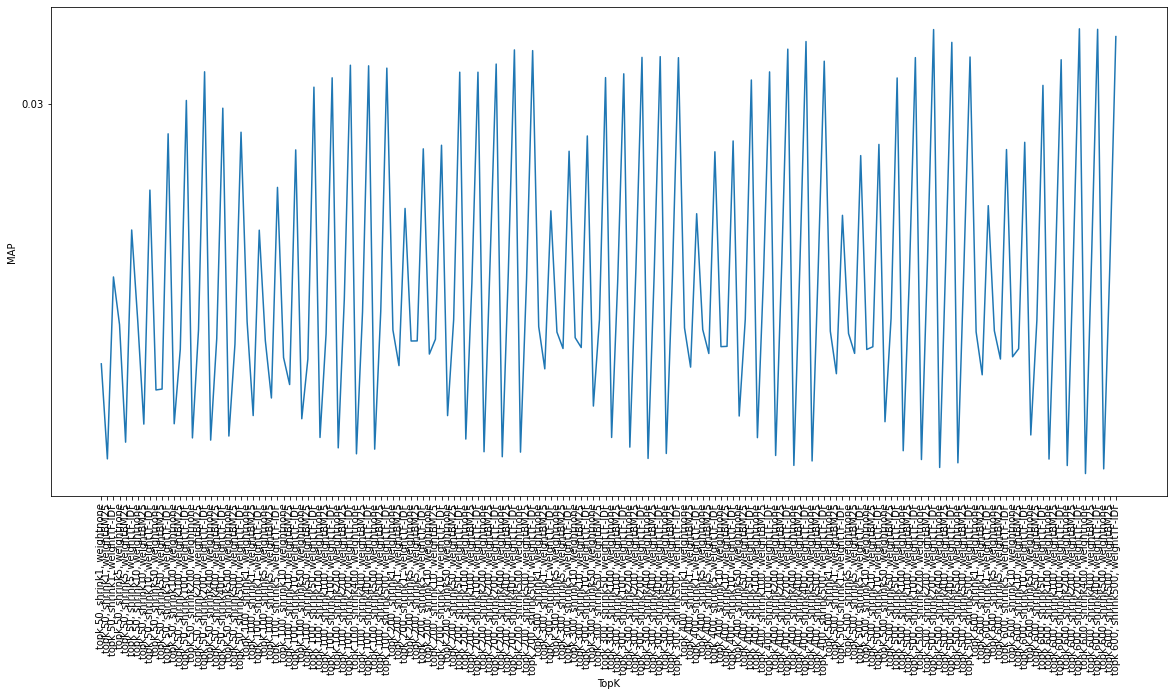

In [28]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(20, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [39]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [40]:
# best model itemCBF topk 600, shrink200, weightTF-IDF

recommender = ItemKNNCBFRecommender(URM_all, ICM_all)
recommender.fit(topK=600, shrink=200, feature_weighting = 'TF-IDF')

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


ItemKNNCBFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 3633.94 column/sec, elapsed time 0.12 min


In [41]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [42]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
